# Single Cell Analysis Code For Filtering and Analyzing Nk1.1+/Nkp46+/Cd3- Cells 

The code below is based on an in-silico filtering approach based on key Natural Killer (NK) gene markers which was first described by Tang et al 2023 https://www.cell.com/cell/pdf/S0092-8674(23)00849-8.pdf

The original paper from which this data was obtained from and analysed in this workbook can be obtained from https://www.nature.com/articles/s41467-020-19917-0#data-availability

Specifically the processed Seurat object which is converted to h5ad file (see below) can be found in this repository https://gitlab.oit.duke.edu/wisdom2020/NatureCommunications

# Prerequisites


The raw.h5ad file is required for the below analysis and was obtained by converting the deposited seurat object to an h5ad file which can be loaded into scanpy as an adata object. The metadata was also extracted and saved as a "pbmc_metadata.csv". The R script for performing this conversion to obtain these files can be made avaialble upon request.

# Overview

The goal of this analysis is to profile cells which express NK markers but do not express CD3 genes in order to specifically profile NK cell transcriptional heterogeneity in the context of a tumour model of methylcholanthrene (mca) induced sarcoma. Increasing evidence suggests the existence of myeloid-like NK cells that express both NK markers and myeloid markers. This analysis seeks to confirm the existence of such cells in cancer and looks to define their differences to classical NKs on a gene and pathway level.

In [4]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Processing seurat object to adata object

In [7]:
adata = sc.read_h5ad('../Input/raw.h5ad')


In [8]:
raw_gene_names = adata.var_names[adata.raw.var_names.astype(int)]

In [9]:
adata = ad.AnnData(X=adata.raw.X, obs=adata.obs.copy(), var=pd.DataFrame(index=raw_gene_names))


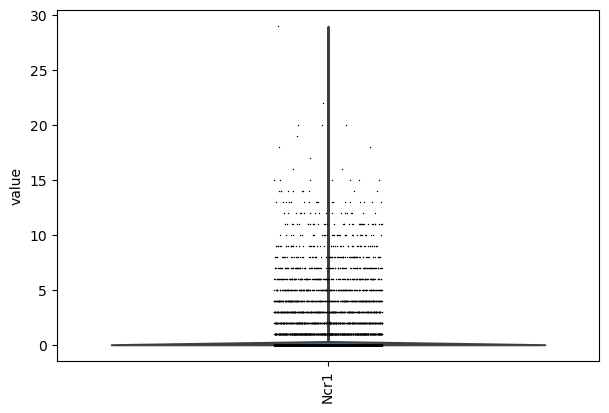

In [10]:
sc.pl.violin(adata, keys=['Ncr1'],rotation=90) # Confirm counts are raw

In [11]:
# Saving raw count data. We will need this later on for the pseudobulk analysis.
adata.layers["counts"] = adata.X.copy()

In [12]:
adata.obs

,orig.ident,percent.mito,sample,res.0.6,nCount_RNA,nFeature_RNA
AAACCTGAGCTTATCG-1,0,0.0,4,3,2003.0,917
AAACCTGAGGGTGTGT-1,0,0.0,4,4,1386.0,665
AAACCTGCATCCAACA-1,0,0.0,4,4,3162.0,1163
AAACCTGTCTAAGCCA-1,0,0.0,4,3,3342.0,1225
AAACGGGAGAGTGACC-1,0,0.0,4,3,1634.0,771
...,...,...,...,...,...,...
TTTGTCATCAATCTCT-28,0,0.0,17,1,5489.0,1790
TTTGTCATCCCATTAT-28,0,0.0,17,1,4176.0,1400
TTTGTCATCCGAAGAG-28,0,0.0,17,9,7296.0,2185
TTTGTCATCTGGCGTG-28,0,0.0,17,18,17873.0,3476


# QC Filtering and Doublet Detection
In the original paper (https://doi.org/10.1038/s41467-020-19917-0) doublet detection was not performed so this needs to be done. I am using DoubletDetection which is readily implemented in scanpy further details can be found here https://github.com/JonathanShor/DoubletDetection


In [13]:
# Basisc QC Filtering Run on Each Sample Seperately
def sample_wise_qc(adata):
    # Get unique sample names
    samples = adata.obs['Sample'].unique()
    
    # List to store filtered AnnData objects
    filtered_adatas = []
    
    for sample in samples:
        # Subset the data for the current sample
        sample_adata = adata[adata.obs['Sample'] == sample].copy()
        
        # Apply QC steps
        sc.pp.filter_cells(sample_adata, min_genes=200)
        sc.pp.filter_genes(sample_adata, min_cells=3)
        
        # Append the filtered sample data to the list
        filtered_adatas.append(sample_adata)
    
    # Concatenate all filtered samples back into a single AnnData object
    combined_adata = sc.concat(filtered_adatas, join='outer')
    
    return combined_adata

In [ ]:
adata = sample_wise_qc(adata)

In [ ]:
adata.write("adata_qc_samplewise.h5ad") # Save This File

In [ ]:
import doubletdetection

Below is the function for running DoubletDetector on an aggregated count matrix. We will wrap this function within another function that runs this on each sample seperately. This is the recommended way of running DoubletDetector|

In [ ]:
# Function for running doublet_score on each sample seperately before integrating all smaples

def detect_doublets_by_sample(adata, n_iters=10, clustering_algorithm="louvain", standard_scaling=True, pseudocount=1, n_jobs=-1, p_thresh=1e-16, voter_thresh=0.5):
    # Create a copy of the original AnnData object
    adata_copy = adata.copy()
    
    # Initialize empty lists to store results
    all_doublet_scores = []
    all_doublets = []
    all_cell_indices = []
    
    # Iterate through each sample
    for sample in adata.obs["Sample"].unique():
        print(f"Processing sample: {sample}")
        
        # Subset the data for the current sample
        adata_sample = adata[adata.obs["Sample"] == sample].copy()
        
        # Initialize the BoostClassifier
        clf = doubletdetection.BoostClassifier(
            n_iters=n_iters,
            clustering_algorithm=clustering_algorithm,
            standard_scaling=standard_scaling,
            pseudocount=pseudocount,
            n_jobs=n_jobs,
        )
        
        # Fit the classifier and predict doublets
        doublets = clf.fit(adata_sample.X).predict(p_thresh=p_thresh, voter_thresh=voter_thresh)
        doublet_score = clf.doublet_score()
        
        # Store results
        all_doublet_scores.extend(doublet_score)
        all_doublets.extend(doublets)
        all_cell_indices.extend(adata_sample.obs.index)
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'doublet_score': all_doublet_scores,
        'is_doublet': all_doublets
    }, index=all_cell_indices)
    
    # Add the results to the original AnnData object
    adata_copy.obs['doublet_score'] = results_df['doublet_score']
    adata_copy.obs['is_doublet'] = results_df['is_doublet']
    
    return adata_copy

In [ ]:
adata = detect_doublets_by_sample(adata)

In [ ]:
# Check Total Number of Doublets across aggregated count matrix. 
# We leave doublets in the adata object to observe presence of doublets in downstream NK filtering.
## These are removed at a later point in the analysis.
sum(adata.obs['is_doublet'] == 1) 

In [ ]:
adata.write("adata_qc_samplewise_doubletdetectiondone.h5ad") # Save This File

# Filtering
Since we are looking to analyse a mouse dataset I have chosen to do the in silico filtering based on the poisitive expression of Klb1c (aka Nk1.1) and Ncr1 (aka Nkp46). These two markers are commonly used in flow sorting to isolate NK cells for downstream assays. As decribed above a negative mask for the expression of the 3 CD3 genes is applied to remove any T/NKT cells.

In [22]:
adata = sc.read_h5ad("../Input/adata_qc_samplewise_doubletdetectiondone.h5ad")

In [23]:
positive_mask = (adata[:, 'Klrb1c'].X.toarray() > 0) | \
                (adata[:, 'Ncr1'].X.toarray() > 0)

In [24]:
adata_filtered = adata[positive_mask, :]
adata_filtered

View of AnnData object with n_obs × n_vars = 3913 × 17176
    obs: 'orig.ident', 'percent.mito', 'sample', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'doublet_score', 'is_doublet'
    layers: 'counts'

In [25]:
negative_mask = (adata_filtered[:, 'Cd3d'].X.toarray() == 0) & \
                (adata_filtered[:, 'Cd3g'].X.toarray() == 0) & \
                (adata_filtered[:, 'Cd3e'].X.toarray() == 0)

In [26]:
adata = adata_filtered[negative_mask,:]
adata

View of AnnData object with n_obs × n_vars = 3244 × 17176
    obs: 'orig.ident', 'percent.mito', 'sample', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'doublet_score', 'is_doublet'
    layers: 'counts'

# Normalisation

In [27]:
# Remove Doublets
adata = adata[adata.obs['is_doublet'] == 0].copy() # First we remove all cells assigned as being doublets

In [28]:
sc.pp.normalize_total(adata, target_sum=1e4) # target 10,000 as done in Cell paper
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


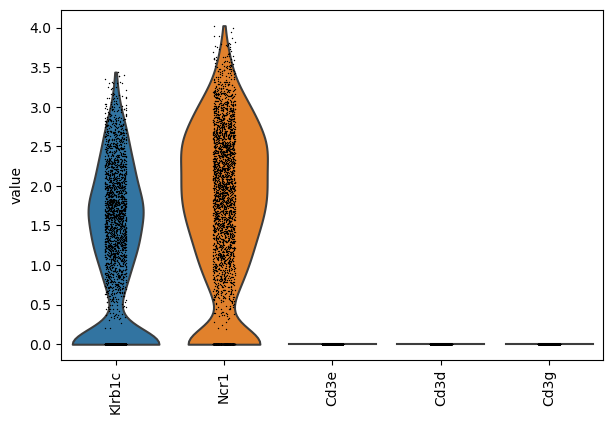

In [29]:
sc.pl.violin(adata, keys=['Klrb1c','Ncr1','Cd3e','Cd3d','Cd3g'],
    rotation=90) # Confirm Cells express either of the two NK markers and neither of the three CD3 Genes

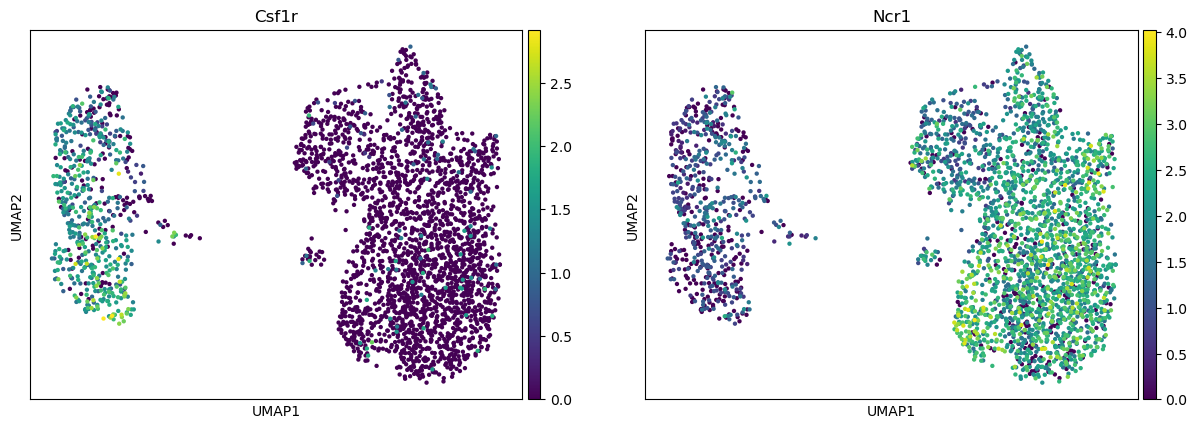

In [30]:
sc.tl.umap(adata)
sc.pl.umap(adata,color=['Csf1r','Ncr1'])

Intrestingly we find two well separated clusters some of which seem to express the myeloid marker Csf1r. This is consistent with the findings by Tang et al 2023.

## Add Metadata

We add the metadata to the adata object which includes sample origin and treatment details. We also have the previous cell annotations from the original analysis which are held in the res.0.6 coloumn. These can be subsequently overlaid on the UMAP to see how closely our filtered NK cells correspond to original clusters defined in the original paper. We later convert these cluster numbers to defined cell types as it makes it visually easier to assess the original cluster assigment.

The sc-RNAseq data has samples orignating from either Primary tumours or Transplant tumours. The different treatments adminstered are covered in the treatment_mapping dictionary below.


In [31]:
metadata = pd.read_csv('../Input/pbmc_metadata.csv', index_col=0)
metadata

,nGene,nUMI,orig.ident,percent.mito,sample,res.0.6
AAACCTGAGCTTATCG-1,917,2003,10X_PBMC,0,AP1,3
AAACCTGAGGGTGTGT-1,665,1386,10X_PBMC,0,AP1,4
AAACCTGCATCCAACA-1,1163,3162,10X_PBMC,0,AP1,4
AAACCTGTCTAAGCCA-1,1225,3342,10X_PBMC,0,AP1,3
AAACGGGAGAGTGACC-1,771,1634,10X_PBMC,0,AP1,3
...,...,...,...,...,...,...
TTTGTCATCAATCTCT-28,1790,5489,10X_PBMC,0,PIR5,1
TTTGTCATCCCATTAT-28,1400,4176,10X_PBMC,0,PIR5,1
TTTGTCATCCGAAGAG-28,2185,7296,10X_PBMC,0,PIR5,9
TTTGTCATCTGGCGTG-28,3476,17873,10X_PBMC,0,PIR5,18


In [32]:
# Define the list of primary tumour samples
primary_tumours = ["PI1", "PI2", "PI3", "PI4", "PI5","PIR1","PIR2","PIR3","PIR4","PIR5","PP1", "PP2", "PP3", "PP4",
                   "PP5","PPR1", "PPR2", "PPR3", "PPR4", "PPR5"]

# Create the 'type' column based on the sample column
metadata['type'] = metadata['sample'].apply(lambda x: 'Primary tumour' if x in primary_tumours else 'Transplant')


In [33]:
treatment_mapping = {
    "PI1": "Primary_Isotype", "PI2": "Primary_Isotype", "PI3": "Primary_Isotype", "PI4": "Primary_Isotype", "PI5": "Primary_Isotype",
    "PIR1": "Primary_Radiotherapy", "PIR2": "Primary_Radiotherapy", "PIR3": "Primary_Radiotherapy", "PIR4": "Primary_Radiotherapy", "PIR5": "Primary_Radiotherapy",
    "PPR1": "Primary_PD1_Radiotherapy", "PPR2": "Primary_PD1_Radiotherapy", "PPR3": "Primary_PD1_Radiotherapy", "PPR4": "Primary_PD1_Radiotherapy", "PPR5": "Primary_PD1_Radiotherapy",
    "PP1": "Primary_PD1", "PP2": "Primary_PD1", "PP3": "Primary_PD1", "PP4": "Primary_PD1", "PP5": "Primary_PD1",
    "AP1": "Transplant_PD1", "AP2": "Transplant_PD1", "AP3": "Transplant_PD1", "AP4": "Transplant_PD1",
    "AI1": "Transplant_Isotype", "AI2": "Transplant_Isotype", "AI3": "Transplant_Isotype", "AI4": "Transplant_Isotype"
}

In [34]:
metadata['treatment'] = metadata['sample'].map(treatment_mapping)


In [35]:
adata.obs['type'] = adata.obs.index.map(metadata['type'].to_dict())
adata.obs['treatment'] = adata.obs.index.map(metadata['treatment'].to_dict())
adata.obs['sample'] = adata.obs.index.map(metadata['sample'].to_dict())

In [36]:
adata.obs # Check the metadata that we have added

,orig.ident,percent.mito,sample,res.0.6,nCount_RNA,nFeature_RNA,n_genes,doublet_score,is_doublet,type,treatment
AAAGATGGTCCAGTAT-1,0,0.0,AP1,7,3011.0,1006,1006,0.000625,0.0,Transplant,Transplant_PD1
AAAGTAGTCCCGGATG-1,0,0.0,AP1,7,1772.0,819,819,0.000625,0.0,Transplant,Transplant_PD1
AACCGCGGTCGAGATG-1,0,0.0,AP1,3,5074.0,1660,1660,6.877347,0.0,Transplant,Transplant_PD1
AAGGAGCCACACCGCA-1,0,0.0,AP1,7,1913.0,776,776,0.000625,0.0,Transplant,Transplant_PD1
AAGGAGCTCTAAGCCA-1,0,0.0,AP1,7,1499.0,771,771,0.000625,0.0,Transplant,Transplant_PD1
...,...,...,...,...,...,...,...,...,...,...,...
TGGACGCCAGCATACT-28,0,0.0,PIR5,7,4237.0,1396,1396,0.207456,0.0,Primary tumour,Primary_Radiotherapy
TTCGAAGCACGACGAA-28,0,0.0,PIR5,9,7532.0,2273,2273,12.360959,0.0,Primary tumour,Primary_Radiotherapy
TTCTCAACACGAAAGC-28,0,0.0,PIR5,2,14871.0,3239,3239,3.176575,0.0,Primary tumour,Primary_Radiotherapy
TTTATGCGTGCGAAAC-28,0,0.0,PIR5,9,7162.0,2120,2120,12.360959,0.0,Primary tumour,Primary_Radiotherapy


/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


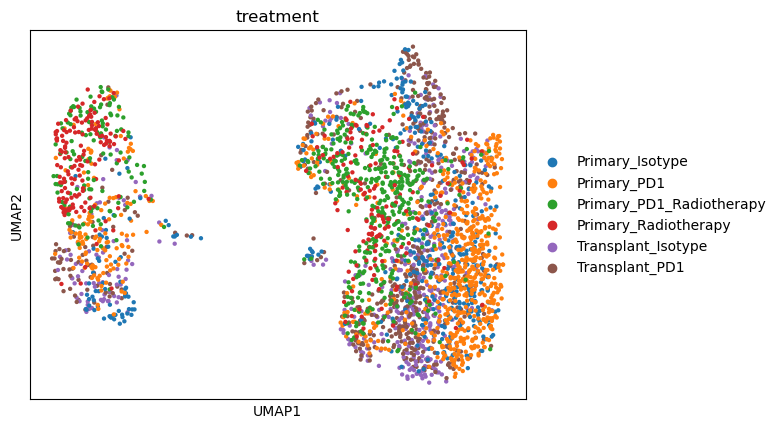

In [43]:
# We can plot a UMAP and split based on treatment type

sc.pl.umap(adata,color='treatment')

# Clustering

In [37]:
sc.tl.leiden(adata,resolution=0.1)

/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


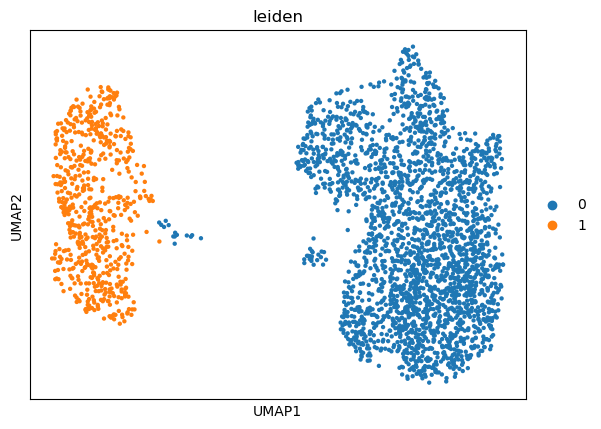

In [39]:
sc.pl.umap(adata,color='leiden')

In [41]:
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")


/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


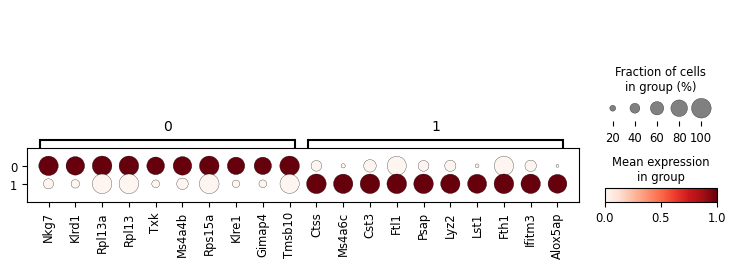

In [42]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=10
)

We can see that cluster 1 has several well known markers including Ctss and Lyz2. These cells seem to be myeloid NK cells.

# Cell Annotation
We overlay the previous cell annotation to see which clusters our filtered (and clustered) cells fall into. We also make use of PangaloDB and an over representation analysis (ORA) for automatic annotation.

/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


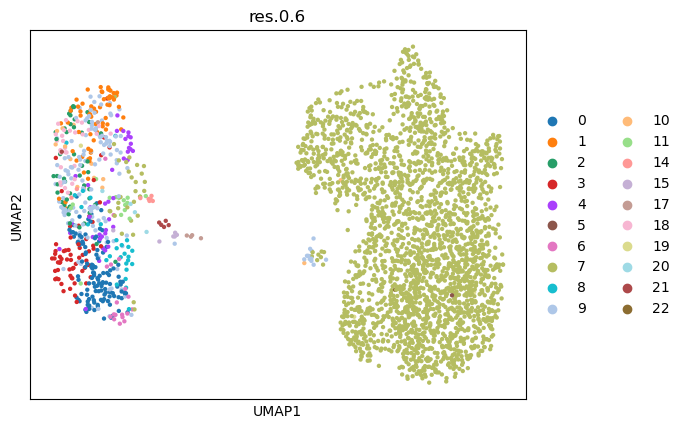

In [44]:
sc.pl.umap(adata, color = ['res.0.6']) # map cell to original cluster done in paper over the UMAP

In [45]:
# Define the mapping dictionary to original assignment in paper
label_to_cell_type = {
    0: 'Monocyte_Macrophage', 1: 'Monocyte_Macrophage', 2: 'Monocyte_Macrophage', 3: 'Monocyte_Macrophage',
    4: 'Monocyte_Macrophage', 6: 'Monocyte_Macrophage', 11: 'Monocyte_Macrophage', 8: 'Monocyte_Macrophage', 18: 'Monocyte_Macrophage',
    7: 'NK_Cells',
    13: 'CD4_T_cells', 12: 'CD4_T_cells',
    5: 'CD8_T_cell',
    14: 'pDC',
    16: 'Lymphoid_undefined', 9: 'Lymphoid_undefined', 21: 'Lymphoid_undefined', 20: 'Lymphoid_undefined', 
    17: 'Lymphoid_undefined', 15: 'Lymphoid_undefined', 22: 'Lymphoid_undefined',
    10: 'Neutrophils',
    19: 'B_cells'
}

# Convert 'res.0.6' to integer and map to cell types
adata.obs['original_cell_identify'] = adata.obs['res.0.6'].astype(int).map(label_to_cell_type)

# Verify the new column
print(adata.obs[['res.0.6', 'original_cell_identify']].head())

                   res.0.6 original_cell_identify
AAAGATGGTCCAGTAT-1       7               NK_Cells
AAAGTAGTCCCGGATG-1       7               NK_Cells
AACCGCGGTCGAGATG-1       3    Monocyte_Macrophage
AAGGAGCCACACCGCA-1       7               NK_Cells
AAGGAGCTCTAAGCCA-1       7               NK_Cells


/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


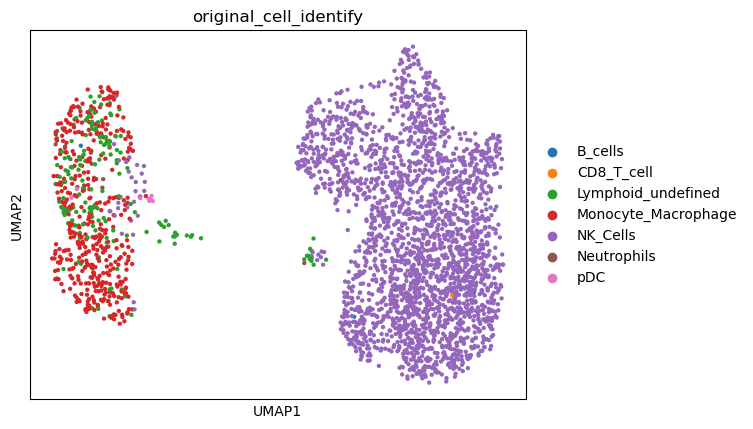

In [46]:
# This plot is a lot clearler to interpret
sc.pl.umap(adata, color = ['original_cell_identify']) # map cell to original cluster done in paper

Indeed most of the cells in cluster 1 seem to map back to Monocyte_Macrophage clusters as annotated in the original paper publication. Lets plot the proportions of cells that fall into each original identity.

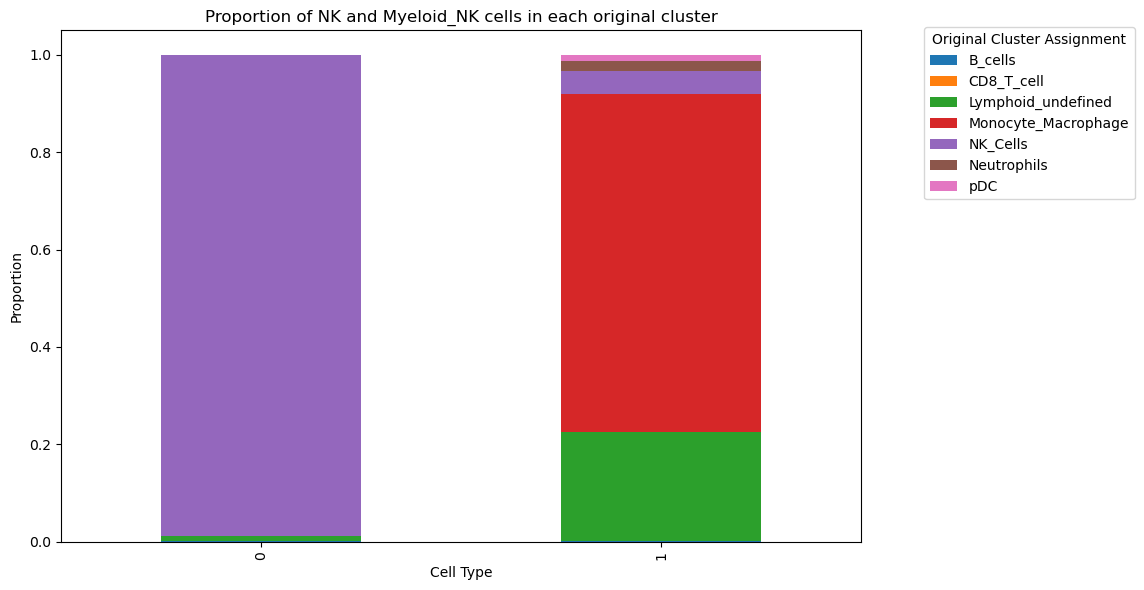

In [47]:
# Create a crosstab to calculate proportions
crosstab_df = pd.crosstab(adata.obs['original_cell_identify'], adata.obs['leiden'], normalize='columns')

# Plotting the data as a stacked bar chart
ax = crosstab_df.T.plot(kind='bar', stacked=True, figsize=(12, 6))

# Formatting the plot
plt.xticks(rotation=90)
ax.legend(title='Original Cluster Assignment', bbox_to_anchor=(1.35, 1.02), loc='upper right')
plt.title('Proportion of NK and Myeloid_NK cells in each original cluster')
plt.ylabel('Proportion')
plt.xlabel('Cell Type')
plt.grid(False)
plt.tight_layout()
plt.show()

# Automatic Annotation 
For more info refer to decoupler webpage https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

In [48]:
# Which cell types do these NK1.1 positive cells resemble

import decoupler as dc
import numpy as np

In [49]:
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [50]:
# Filter by canonical_marker and human
markers = markers[markers['mouse'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

# We need to convert to mouse genes as our dataset is a mouse one
markers = dc.translate_net(markers, target_organism = 'mouse', unique_by = ('genesymbol'))
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,Ctrb1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
1,Klk1b21,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
2,Klk1b11,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
3,Klk1b4,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
4,Klk1b27,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,Lpcat1,True,Pulmonary alveolar type II cells,Endoderm,True,0.692308,0.007864,True,0.856061,0.021743,9606,Lungs,0.025
526,Cd3d,True,T cells,Mesoderm,True,0.964427,0.057162,True,0.864486,0.026283,9606,Immune system,0.053
527,Trac,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
529,Lck,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


In [51]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

2410 features of mat are empty, they will be removed.
Running ora on mat with 3052 samples and 14766 targets for 36 sources.


100%|█████████████████████████████████████| 3052/3052 [00:02<00:00, 1396.66it/s]


In [52]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3052 × 36
    obs: 'orig.ident', 'percent.mito', 'sample', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'doublet_score', 'is_doublet', 'type', 'treatment', 'leiden', 'original_cell_identify'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'treatment_colors', 'res.0.6_colors', 'original_cell_identify_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

In [53]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Gamma delta T cells,63.812592,1.647992,0.000000e+00,0.000000e+00
1,0,rest,NK cells,50.109832,1.919492,0.000000e+00,0.000000e+00
2,0,rest,B cells naive,31.584283,0.532490,2.287128e-195,6.861384e-195
3,0,rest,T cells,31.083843,0.719731,2.698617e-187,7.473092e-187
4,0,rest,Pancreatic stellate cells,23.518603,0.172257,8.462039e-116,1.903959e-115
...,...,...,...,...,...,...,...
67,1,rest,Pancreatic stellate cells,-11.826691,-0.172257,1.314178e-30,2.956901e-30
68,1,rest,T cells,-15.630988,-0.719731,9.474468e-49,2.623699e-48
69,1,rest,B cells naive,-15.882642,-0.532490,8.446846e-51,2.534054e-50
70,1,rest,NK cells,-25.198498,-1.919492,1.383604e-109,8.301623e-109


In [54]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Gamma delta T cells', '1': 'Dendritic cells'}

In [55]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Gamma delta T cells', 'NK cells', 'B cells naive'],
 '1': ['Dendritic cells', 'Ductal cells', 'Macrophages']}

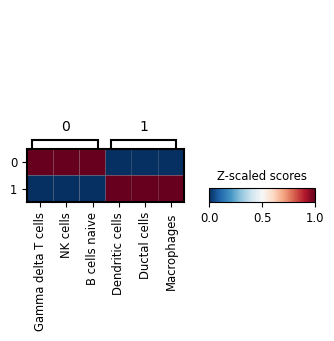

In [56]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

Again Cluster 1 seems to be assigned to Myeloid Like Cells instead of NK cells. Lets plot the scores for individual cells and project onto the UMAP

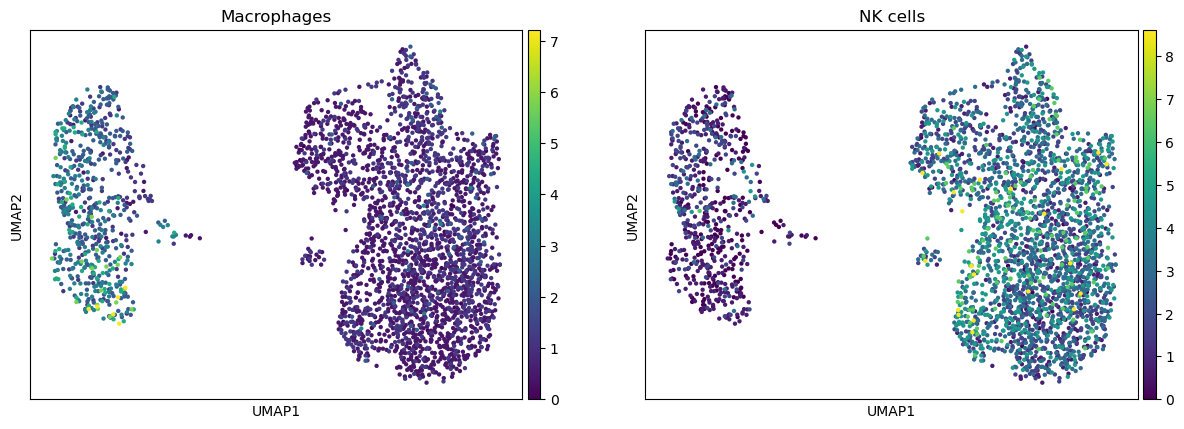

In [57]:
sc.pl.umap(acts, color=['Macrophages','NK cells'])


Given this lets rename our clusters to refelct these cell types:

In [63]:
new_cluster_names = [
    "NK",
    "Myeloid_NK"
]
adata.rename_categories("leiden", new_cluster_names)

# The below code is for doing a GSEA analysis
We follow sc-RNAseq best practices workflow for this analysis. We make use of GO-BP and Reactome databases. https://www.sc-best-practices.org/conditions/gsea_pathway.html

In [64]:
# extract scores
t_stats = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, group="Myeloid_NK")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["NK_v_Myeloid"], axis=1)
)
t_stats

NK_v_Myeloid,scores
names,
Ctss,38.058907
Ms4a6c,37.359406
Cst3,37.328213
Psap,36.671806
Lst1,36.176487
...,...
Wdr90,-0.002482
Bbs12,0.002201
Zfp770,0.001842


In [65]:
import decoupler

In [67]:
# msigdb['collection'].unique().tolist()

# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'go_biological_process'") # or reactome
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]

# Convert to mouse genes

reactome = decoupler.translate_net(reactome, target_organism = 'mouse', unique_by = ('geneset', 'genesymbol'))
reactome

,genesymbol,collection,geneset
0,Maff,go_biological_process,GOBP_EMBRYO_DEVELOPMENT
1,Maff,go_biological_process,GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS
2,Maff,go_biological_process,GOBP_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIA...
3,Maff,go_biological_process,GOBP_EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG...
4,Maff,go_biological_process,GOBP_IN_UTERO_EMBRYONIC_DEVELOPMENT
...,...,...,...
516939,Tspyl1,go_biological_process,GOBP_MULTICELLULAR_ORGANISM_REPRODUCTION
517009,Ddx3y,go_biological_process,GOBP_REPRODUCTION
517010,Ddx3y,go_biological_process,GOBP_GAMETE_GENERATION
517011,Ddx3y,go_biological_process,GOBP_SEXUAL_REPRODUCTION


In [68]:
# Filter gene set sizes
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [69]:
scores, norm, pvals = decoupler.run_gsea(
    t_stats.T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("norm")
)

In [70]:
#Filter gsea results based on sig pval
gsea_results = gsea_results[gsea_results['pval'] < 0.05]

# split into pathways enriched in myeloid_nk vs nk

gsea_my = gsea_results[gsea_results['score'] > 0]

gsea_nk = gsea_results[gsea_results['score'] < 0]

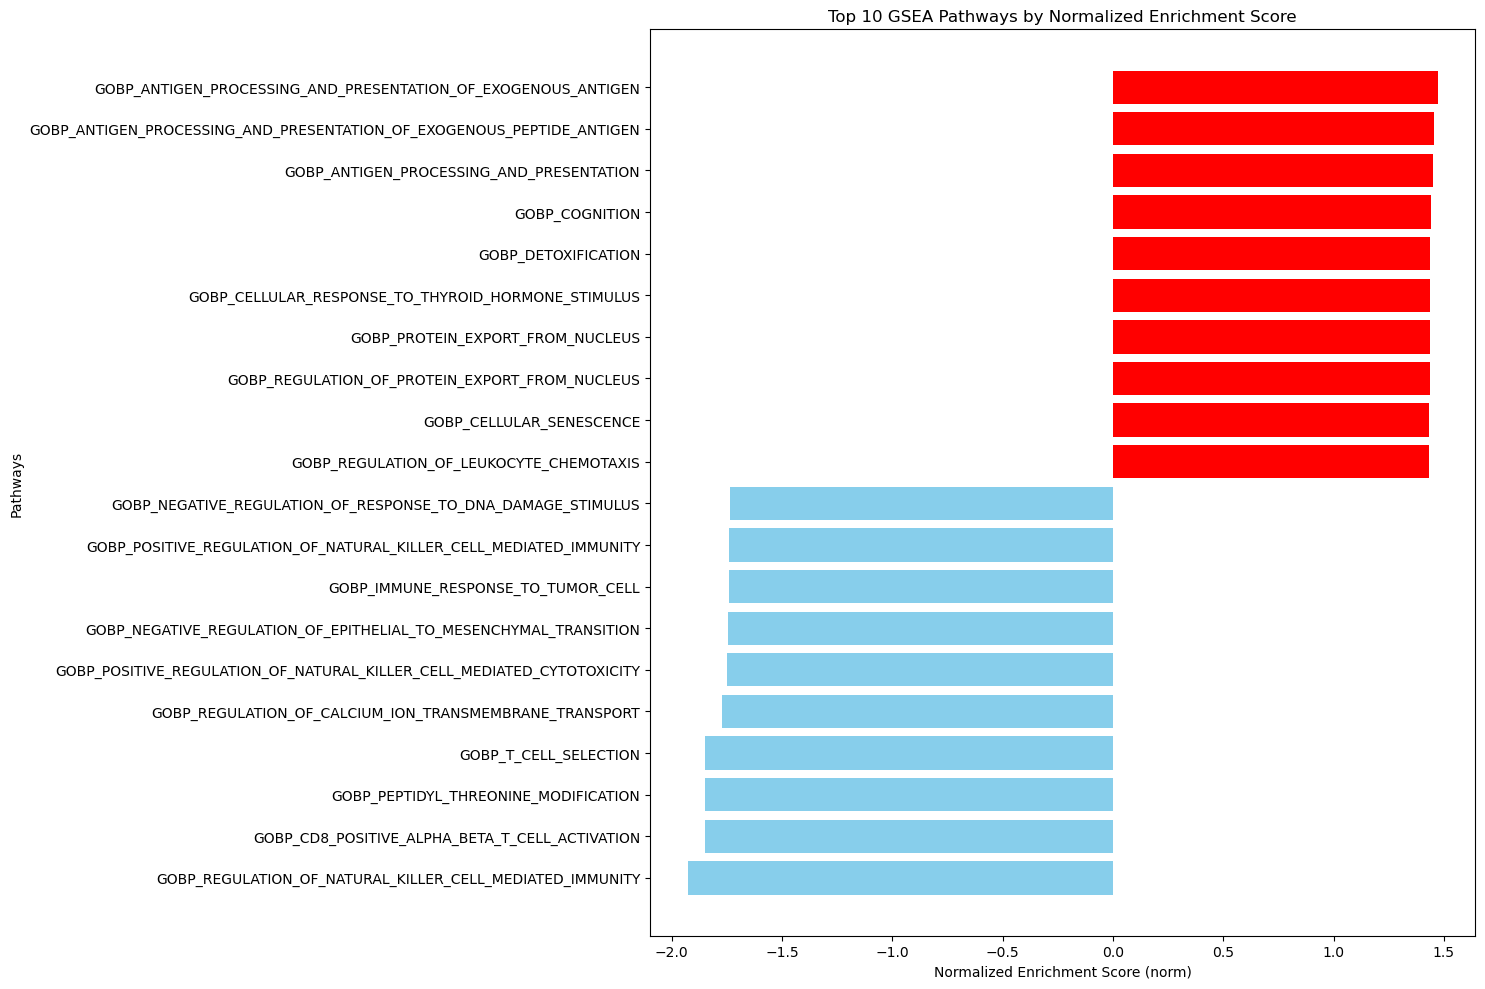

In [71]:
# Select top 10 highest norm values for myeliod and nk (tail since descending order and negative values)
bottom_10 = gsea_my.tail(10)
top_10 = gsea_nk.head(10)

# Concatenate top 10 and bottom 10
top_bottom_gsea_results = pd.concat([top_10, bottom_10])

colors = ['skyblue'] * len(top_10) + ['red'] * len(bottom_10)


fig, ax = plt.subplots(figsize=(12, 10))  # Increased height to 10

# Plot norm values
ax.barh(top_bottom_gsea_results.index, top_bottom_gsea_results['norm'], color=colors)

# Customize the plot
ax.set_xlabel('Normalized Enrichment Score (norm)')
ax.set_ylabel('Pathways')
ax.set_title('Top 10 GSEA Pathways by Normalized Enrichment Score')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Add more space to the left of the plot for pathway names
plt.subplots_adjust(left=0.3)

plt.grid(False)

# Show the plot
plt.show()

Enriched pathways in line with Myeloid NK cells being myeloid like and NK cells being Classical NK cells

# Transcription Factor Activity Inference

In [73]:
import decoupler as dc

In [74]:
net = dc.get_collectri(organism='mouse', split_complexes=False)
net

,source,target,weight,PMID
0,Myc,Tert,1,10022128;10491298;10606235;10637317;10723141;1...
1,Spi1,Bglap,1,10022617
2,Spi1,Bglap3,1,10022617
3,Spi1,Bglap2,1,10022617
4,Smad3,Jun,1,10022869;12374795
...,...,...,...,...
38660,Runx1,Lcp2,1,20019798
38661,Runx1,Prr5l,1,20019798
38662,Twist1,Gli1,1,11948912
38663,Usf1,Nup188,1,22951020


In [75]:
adata.raw = adata


In [76]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

2410 features of mat are empty, they will be removed.
Running ulm on mat with 3052 samples and 14766 targets for 617 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


In [77]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 3052 × 17176
    obs: 'orig.ident', 'percent.mito', 'sample', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'doublet_score', 'is_doublet', 'type', 'treatment', 'leiden', 'original_cell_identify'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'treatment_colors', 'res.0.6_colors', 'original_cell_identify_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [78]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 3052 × 617
    obs: 'orig.ident', 'percent.mito', 'sample', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'doublet_score', 'is_doublet', 'type', 'treatment', 'leiden', 'original_cell_identify'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'treatment_colors', 'res.0.6_colors', 'original_cell_identify_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

In [80]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,Myeloid_NK,rest,Spi1,55.448355,4.126888,1.747054e-314,1.077932e-311
1,Myeloid_NK,rest,Cebpg,53.074958,3.523263,1.836175e-297,2.832301e-295
2,Myeloid_NK,rest,Cebpb,52.740705,3.209765,3.924854e-302,8.072116e-300
3,Myeloid_NK,rest,Sp1,52.689652,3.239244,1.917653e-308,5.915960e-306
4,Myeloid_NK,rest,Ehf,50.838606,3.330634,2.196458e-285,2.710430e-283
...,...,...,...,...,...,...,...
1229,NK,rest,Ehf,-101.097849,-3.330634,0.000000e+00,0.000000e+00
1230,NK,rest,Sp1,-104.778847,-3.239244,0.000000e+00,0.000000e+00
1231,NK,rest,Cebpb,-104.880372,-3.209765,0.000000e+00,0.000000e+00
1232,NK,rest,Cebpg,-105.545068,-3.523263,0.000000e+00,0.000000e+00


/Users/stefanmilutin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


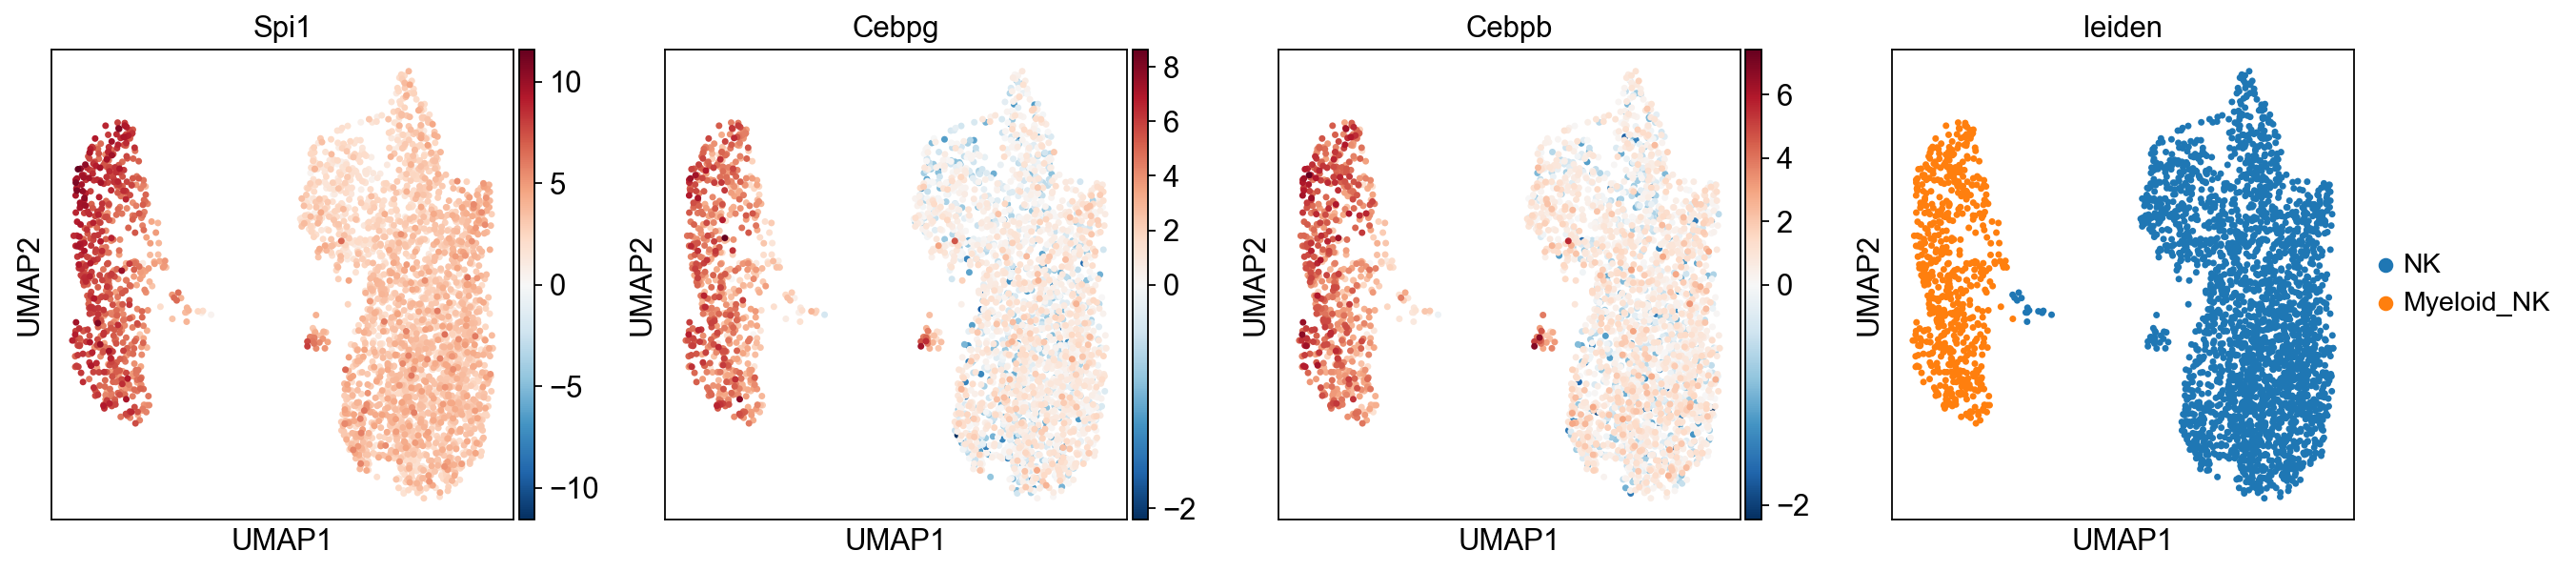

In [83]:
sc.pl.umap(acts, color=['Spi1', 'Cebpg', 'Cebpb', 'leiden'], cmap='RdBu_r', vcenter=0)


Again Key Transcription Factors that are expressed by myeloid cells are found expressed in this cluster as well.